In [1]:
import torch, torchaudio, torchvision.transforms as transforms, matplotlib.pyplot as plt, torch.nn as nn, torch.optim as optim, numpy as np
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import sys
sys.path.append("../")
from ad_utils import *
import warnings
warnings.filterwarnings('ignore')


cuda0 = torch.device("cuda:0")
cuda1 = torch.device("cuda:1")
device = cuda1
print(torch.cuda.get_device_name(device) if torch.cuda.is_available() else "No GPU available")

data = np.load("../../hvcm/RFQ.npy", allow_pickle=True)
label = np.load("../../hvcm/RFQ_labels.npy", allow_pickle=True)
label = label[:, 1]  # Assuming the second column is the label
label = (label == "Fault").astype(int)  # Convert to binary labels
print(data.shape, label.shape)

scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)

normal_data = data[label == 0]
faulty_data = data[label == 1]

normal_label = label[label == 0]
faulty_label = label[label == 1]

X_train, X_test, y_train, y_test = train_test_split(normal_data, normal_label, test_size=0.2, random_state=42, stratify=normal_label)


NVIDIA A30
(872, 4500, 14) (872,)


# Wasserstein GAN

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.autograd import grad

# Attention mechanism for enhanced anomaly detection
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv1d(in_channels, in_channels // 8, 1)
        self.key_conv = nn.Conv1d(in_channels, in_channels // 8, 1)
        self.value_conv = nn.Conv1d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        batch_size, channels, length = x.size()
        
        proj_query = self.query_conv(x).view(batch_size, -1, length).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, length)
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        
        proj_value = self.value_conv(x).view(batch_size, -1, length)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, channels, length)
        
        out = self.gamma * out + x
        return out

# Enhanced WGAN Generator with attention and residual connections
class EnhancedWGANGenerator(nn.Module):
    def __init__(self, latent_dim=100, n_features=14, seq_len=4500):
        super(EnhancedWGANGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.n_features = n_features
        self.seq_len = seq_len
        
        # Calculate reasonable initial size
        self.init_size = max(seq_len // 64, 32)
        
        # Initial projection with residual connection
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256 * self.init_size),
            nn.BatchNorm1d(256 * self.init_size),
            nn.ReLU(inplace=True)
        )
        
        # Residual blocks for better gradient flow
        self.conv_blocks = nn.ModuleList([
            # Block 1: 256 -> 128 channels
            nn.Sequential(
                nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm1d(128),
                nn.ReLU(inplace=True),
            ),
            # Block 2: 128 -> 64 channels with attention
            nn.Sequential(
                nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm1d(64),
                nn.ReLU(inplace=True),
            ),
            # Block 3: 64 -> 32 channels
            nn.Sequential(
                nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm1d(32),
                nn.ReLU(inplace=True),
            ),
            # Final block: 32 -> n_features
            nn.Sequential(
                nn.ConvTranspose1d(32, n_features, kernel_size=4, stride=2, padding=1),
                nn.Tanh()
            )
        ])
        
        # Self-attention for anomaly-aware generation
        self.attention = SelfAttention(64)
        
    def forward(self, z):
        # Project latent to initial conv size
        out = self.fc(z)
        out = out.view(out.shape[0], 256, self.init_size)
        
        # Progressive upsampling with attention
        for i, block in enumerate(self.conv_blocks):
            out = block(out)
            # Apply attention after second block (64 channels)
            if i == 1:
                out = self.attention(out)
        
        # Ensure exact sequence length
        if out.shape[2] != self.seq_len:
            out = nn.functional.interpolate(out, size=self.seq_len, mode='linear', align_corners=False)
        
        # Return as (batch_size, seq_len, n_features)
        return out.transpose(1, 2)

# Multi-scale WGAN Critic for better anomaly detection
class MultiScaleWGANCritic(nn.Module):
    def __init__(self, n_features=14, seq_len=4500):
        super(MultiScaleWGANCritic, self).__init__()
        
        # Multi-scale convolutional paths
        self.scale1_conv = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv1d(n_features, 32, kernel_size=3, stride=1, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.scale2_conv = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv1d(n_features, 32, kernel_size=7, stride=1, padding=3)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.scale3_conv = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv1d(n_features, 32, kernel_size=15, stride=1, padding=7)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Fusion layer
        self.fusion = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv1d(192, 128, kernel_size=3, stride=1, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),
        )
        
        # Further downsampling
        self.downsample = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Calculate output size after convolutions
        self.conv_output_size = self._get_conv_output_size(seq_len)
        
        # Classifier with better regularization
        self.classifier = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(512 * self.conv_output_size, 256)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.utils.spectral_norm(nn.Linear(256, 64)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.utils.spectral_norm(nn.Linear(64, 1))
        )
        
    def _get_conv_output_size(self, seq_len):
        size = seq_len
        # scale conv: stride=2, then downsample: stride=2, stride=2
        size = (size - 4 + 2) // 2 + 1  # First downsample
        size = (size - 4 + 2) // 2 + 1  # Second downsample
        size = (size - 4 + 2) // 2 + 1  # Third downsample
        return size
    
    def forward(self, x):
        # Input: (batch_size, seq_len, n_features)
        x = x.transpose(1, 2)  # Convert to (batch_size, n_features, seq_len)
        
        # Multi-scale feature extraction
        scale1_features = self.scale1_conv(x)
        scale2_features = self.scale2_conv(x)
        scale3_features = self.scale3_conv(x)
        
        # Concatenate multi-scale features
        multi_scale_features = torch.cat([scale1_features, scale2_features, scale3_features], dim=1)
        
        # Fusion and further processing
        fused_features = self.fusion(multi_scale_features)
        features = self.downsample(fused_features)
        
        # Flatten and classify
        features = features.view(features.size(0), -1)
        output = self.classifier(features)
        
        return output

# Enhanced gradient penalty computation
def compute_enhanced_gradient_penalty(critic, real_samples, fake_samples, device, lambda_gp=10):
    batch_size = real_samples.size(0)
    
    # Random interpolation coefficient
    alpha = torch.rand(batch_size, 1, 1, device=device)
    alpha = alpha.expand_as(real_samples)
    
    # Create interpolated samples
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    
    # Get critic scores
    d_interpolates = critic(interpolates)
    
    # Compute gradients
    gradients = grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates, device=device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    # Reshape gradients
    gradients = gradients.reshape(batch_size, -1)
    
    # Compute gradient penalty with small epsilon for stability
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    return gradient_penalty

# Enhanced training function with improved stability
def train_enhanced_wgan(normal_data, device, n_epochs=100, batch_size=32, lr_g=1e-4, lr_d=1e-4):
    """
    Enhanced WGAN training with multi-scale critic and attention generator
    """
    print(f"Starting Enhanced WGAN Training with Multi-Scale Architecture")
    print(f"Data shape: {normal_data.shape}")
    print(f"Data range: [{normal_data.min():.4f}, {normal_data.max():.4f}]")
    
    # Model parameters
    latent_dim = 100
    n_features = normal_data.shape[-1]
    seq_len = normal_data.shape[1]
    
    # Initialize enhanced models
    generator = EnhancedWGANGenerator(latent_dim, n_features, seq_len).to(device)
    critic = MultiScaleWGANCritic(n_features, seq_len).to(device)
    
    # Xavier initialization for stability
    def init_weights(m):
        if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d, nn.Linear)):
            nn.init.xavier_normal_(m.weight, gain=0.02)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.constant_(m.bias, 0)
    
    generator.apply(init_weights)
    critic.apply(init_weights)
    
    # Optimizers with different learning rates
    optimizer_G = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.0, 0.9))
    optimizer_C = optim.Adam(critic.parameters(), lr=lr_d, betas=(0.0, 0.9))
    
    # Training parameters
    n_critic = 5  # Train critic more often
    lambda_gp = 10  # Gradient penalty coefficient
    
    # Create dataloader
    dataset = TensorDataset(torch.tensor(normal_data, dtype=torch.float32))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    print(f"Training Parameters:")
    print(f"  Epochs: {n_epochs}, Batch Size: {batch_size}")
    print(f"  Generator LR: {lr_g}, Critic LR: {lr_d}")
    print(f"  Critic Updates per Generator Update: {n_critic}")
    
    # Training history
    d_losses = []
    g_losses = []
    wasserstein_distances = []
    
    print("\nStarting Training...")
    print("=" * 60)
    
    for epoch in range(n_epochs):
        epoch_d_losses = []
        epoch_g_losses = []
        epoch_wd = []
        
        for i, (real_samples,) in enumerate(dataloader):
            real_samples = real_samples.to(device)
            batch_size_actual = real_samples.size(0)
            
            # ========================
            # Train Critic
            # ========================
            for critic_iter in range(n_critic):
                optimizer_C.zero_grad()
                
                # Real samples
                real_validity = critic(real_samples)
                
                # Generate fake samples
                z = torch.randn(batch_size_actual, latent_dim, device=device)
                fake_samples = generator(z).detach()
                fake_validity = critic(fake_samples)
                
                # Wasserstein distance
                wasserstein_distance = torch.mean(real_validity) - torch.mean(fake_validity)
                
                # Gradient penalty
                gradient_penalty = compute_enhanced_gradient_penalty(
                    critic, real_samples, fake_samples, device, lambda_gp
                )
                
                # Critic loss
                c_loss = -wasserstein_distance + lambda_gp * gradient_penalty
                
                c_loss.backward()
                
                # Gradient clipping for stability
                torch.nn.utils.clip_grad_norm_(critic.parameters(), 0.5)
                
                optimizer_C.step()
                
                if critic_iter == n_critic - 1:
                    epoch_d_losses.append(c_loss.item())
                    epoch_wd.append(wasserstein_distance.item())
            
            # ========================
            # Train Generator
            # ========================
            optimizer_G.zero_grad()
            
            # Generate fake samples
            z = torch.randn(batch_size_actual, latent_dim, device=device)
            fake_samples = generator(z)
            fake_validity = critic(fake_samples)
            
            # Generator loss
            g_loss = -torch.mean(fake_validity)
            
            g_loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(generator.parameters(), 0.5)
            
            optimizer_G.step()
            
            epoch_g_losses.append(g_loss.item())
        
        # Calculate epoch averages
        avg_d_loss = np.mean(epoch_d_losses)
        avg_g_loss = np.mean(epoch_g_losses)
        avg_wd = np.mean(epoch_wd)
        
        d_losses.append(avg_d_loss)
        g_losses.append(avg_g_loss)
        wasserstein_distances.append(avg_wd)
        
        # Print progress
        if epoch % 10 == 0 or epoch == n_epochs - 1:
            print(f"Epoch [{epoch+1:3d}/{n_epochs}] | "
                  f"C Loss: {avg_d_loss:8.4f} | "
                  f"G Loss: {avg_g_loss:8.4f} | "
                  f"W-Dist: {avg_wd:8.4f}")
            
            # Enhanced stability check
            if len(d_losses) >= 10:
                recent_d_std = np.std(d_losses[-10:])
                recent_g_std = np.std(g_losses[-10:])
                
                if recent_d_std < 10.0 and recent_g_std < 10.0:
                    print("         ✅ Training highly stable")
                elif recent_d_std < 50.0 and recent_g_std < 50.0:
                    print("         🔄 Training moderately stable")
                else:
                    print("         ⚠️  Training showing variation")
    
    print("=" * 60)
    print("Enhanced WGAN training completed!")
    
    return generator, critic, d_losses, g_losses, wasserstein_distances

# Enhanced sample generation
def generate_enhanced_samples(generator, num_samples, latent_dim, device, batch_size=32):
    """
    Generate samples using enhanced generator
    """
    generator.eval()
    
    generated_batches = []
    
    with torch.no_grad():
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            current_batch_size = end - start
            
            # Generate noise
            z = torch.randn(current_batch_size, latent_dim, device=device)
            
            # Generate samples
            batch_generated = generator(z)
            generated_batches.append(batch_generated.cpu().numpy())
    
    return np.concatenate(generated_batches, axis=0)

# Enhanced visualization
def plot_enhanced_training_curves(d_losses, g_losses, wasserstein_distances):
    """
    Plot training curves with enhanced visualization
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Critic loss
    axes[0, 0].plot(d_losses, label='Critic Loss', color='blue', alpha=0.7)
    axes[0, 0].set_title('Critic Loss Over Time')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Generator loss
    axes[0, 1].plot(g_losses, label='Generator Loss', color='red', alpha=0.7)
    axes[0, 1].set_title('Generator Loss Over Time')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Wasserstein distance
    axes[1, 0].plot(wasserstein_distances, label='Wasserstein Distance', color='green', alpha=0.7)
    axes[1, 0].set_title('Wasserstein Distance Over Time')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Distance')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Moving average of losses for stability analysis
    window_size = 10
    if len(d_losses) >= window_size:
        d_ma = pd.Series(d_losses).rolling(window=window_size).mean()
        g_ma = pd.Series(g_losses).rolling(window=window_size).mean()
        
        axes[1, 1].plot(d_ma, label=f'Critic Loss (MA-{window_size})', color='blue', alpha=0.7)
        axes[1, 1].plot(g_ma, label=f'Generator Loss (MA-{window_size})', color='red', alpha=0.7)
        axes[1, 1].set_title('Training Stability (Moving Average)')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Loss')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# WGANS Training

Training Enhanced WGAN with Multi-Scale Architecture...
Starting Enhanced WGAN Training with Multi-Scale Architecture
Data shape: (552, 4500, 14)
Data range: [-5.7245, 7.6610]
Training Parameters:
  Epochs: 80, Batch Size: 32
  Generator LR: 0.0001, Critic LR: 0.0002
  Critic Updates per Generator Update: 5

Starting Training...
Epoch [  1/80] | C Loss: -623.8853 | G Loss: -17.8085 | W-Dist: 726.0326
Epoch [ 11/80] | C Loss: -1389.0047 | G Loss: -510.8146 | W-Dist: 2050.9978
         ⚠️  Training showing variation
Epoch [ 21/80] | C Loss: -1010.7365 | G Loss: -908.1314 | W-Dist: 1659.0567
         ⚠️  Training showing variation
Epoch [ 31/80] | C Loss: -867.7938 | G Loss: -993.8013 | W-Dist: 1405.2215
         🔄 Training moderately stable
Epoch [ 41/80] | C Loss: -715.0408 | G Loss: -1084.3867 | W-Dist: 1169.2664
         🔄 Training moderately stable
Epoch [ 51/80] | C Loss: -607.8669 | G Loss: -1117.6333 | W-Dist: 1006.0164
         🔄 Training moderately stable
Epoch [ 61/80] | C Loss

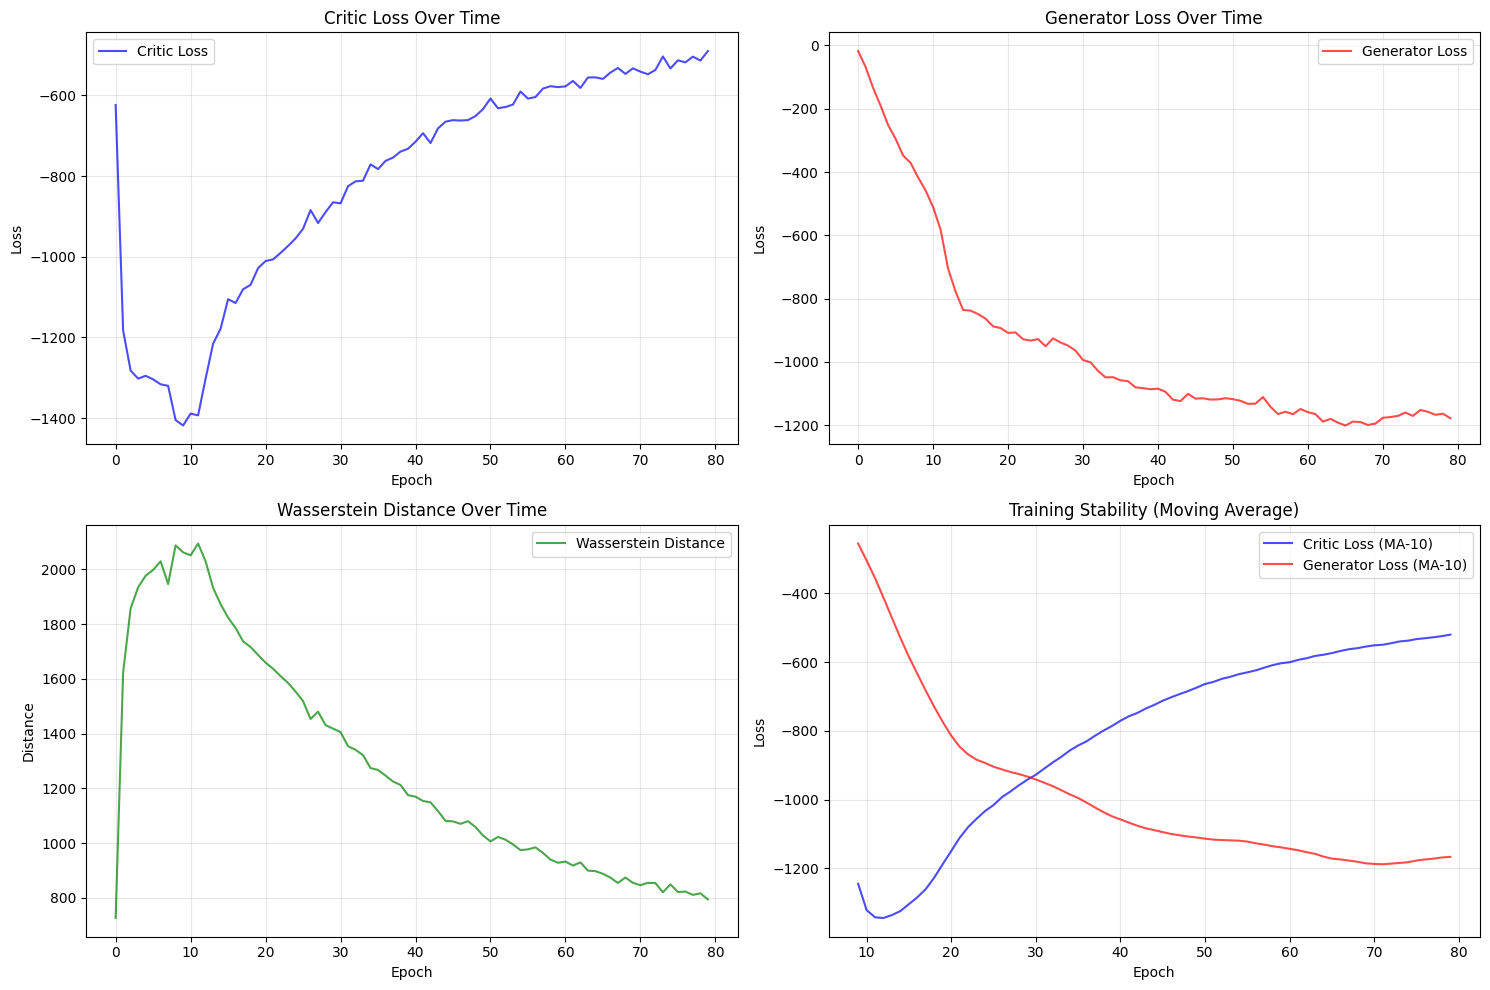

In [3]:
# Train the enhanced WGAN with multi-scale critic and attention generator
print("Training Enhanced WGAN with Multi-Scale Architecture...")
generator, critic, d_history, g_history, wd_history = train_enhanced_wgan(
    X_train,
    device,
    n_epochs=80,
    batch_size=32,
    lr_g=1e-4,     # Optimized learning rates
    lr_d=2e-4
)

# Plot enhanced training curves
plot_enhanced_training_curves(d_history, g_history, wd_history)



# Generate and Combine

Generating synthetic samples with Enhanced WGAN...
Generated data shape: (552, 4500, 14)
Generated data range: [-1.0000, 1.0000]
Original data range: [-5.7248, 7.6610]
✅ Enhanced WGAN training and generation completed!


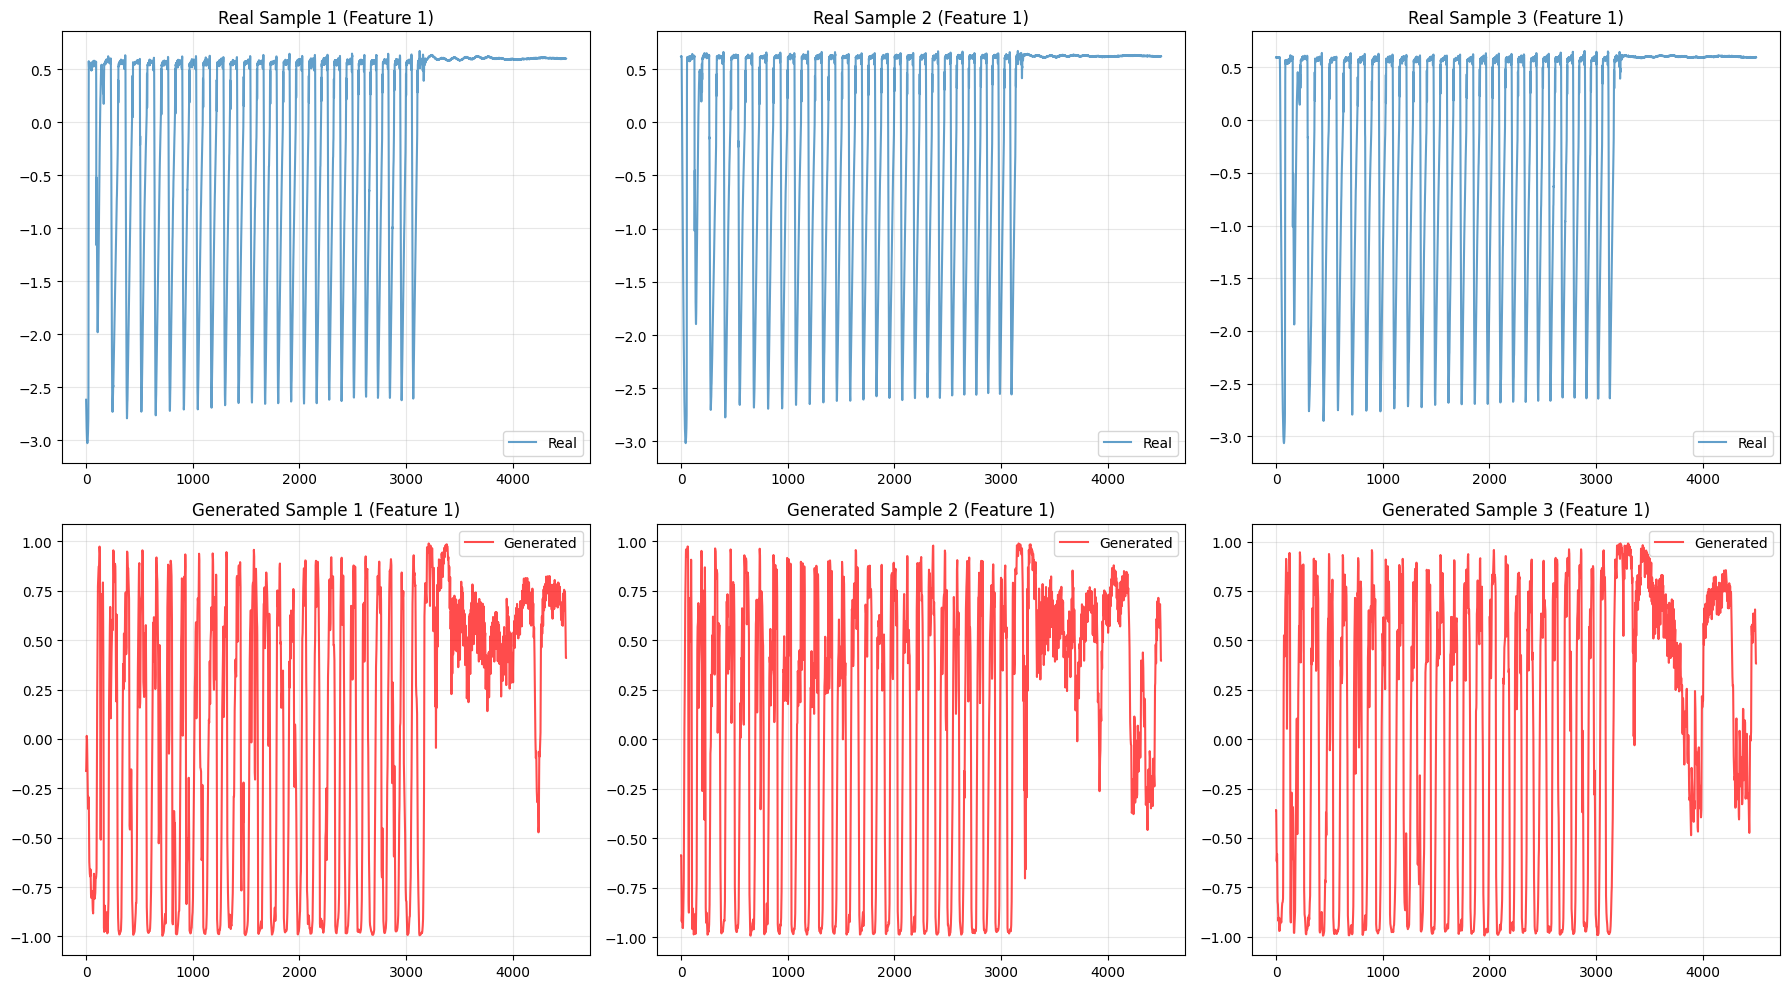

In [4]:
# Generate samples using enhanced generator
print("Generating synthetic samples with Enhanced WGAN...")
generated_data = generate_enhanced_samples(
    generator,
    len(X_train),
    latent_dim=100,
    device=device,
    batch_size=32
)

print(f"Generated data shape: {generated_data.shape}")
print(f"Generated data range: [{generated_data.min():.4f}, {generated_data.max():.4f}]")
print(f"Original data range: [{normal_data.min():.4f}, {normal_data.max():.4f}]")

# Combine with real data
combine_data_normal = np.concatenate((generated_data, normal_data), axis=0)
combine_labels_normal = np.concatenate((np.zeros(len(generated_data)), normal_label), axis=0)

print("✅ Enhanced WGAN training and generation completed!")

# Visualize sample comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Select random samples for visualization
n_viz = 3
real_indices = np.random.choice(len(normal_data), n_viz, replace=False)
fake_indices = np.random.choice(len(generated_data), n_viz, replace=False)

for i in range(n_viz):
    # Real samples
    axes[0, i].plot(normal_data[real_indices[i], :, 0], alpha=0.7, label='Real')
    axes[0, i].set_title(f'Real Sample {i+1} (Feature 1)')
    axes[0, i].legend()
    axes[0, i].grid(True, alpha=0.3)
    
    # Generated samples
    axes[1, i].plot(generated_data[fake_indices[i], :, 0], alpha=0.7, label='Generated', color='red')
    axes[1, i].set_title(f'Generated Sample {i+1} (Feature 1)')
    axes[1, i].legend()
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
# ===============================
# FID SCORE EVALUATION
# ===============================

# Test the simplified FID calculation
print("Testing simplified FID calculation...")

# Use smaller subsets for testing
test_real = X_train[:100]  # Use 100 samples for testing
test_generated = generated_data[:100]

print(f"Test real data shape: {test_real.shape}")
print(f"Test generated data shape: {test_generated.shape}")

# Calculate FID score
fid_score = calculate_fid_score(
    real_data=test_real,
    fake_data=test_generated,
    device=device,
    sample_rate=1000,
)

if fid_score is not None:
    print(f"\n🎉 SUCCESS! FID Score: {fid_score:.4f}")
    
    # Interpret the score
    if fid_score < 10:
        quality = "Excellent"
    elif fid_score < 25:
        quality = "Good"
    elif fid_score < 50:
        quality = "Fair"
    elif fid_score < 100:
        quality = "Poor"
    else:
        quality = "Very Poor"
    
    print(f"Quality Assessment: {quality}")
else:
    print("❌ FID calculation failed. Please check the error messages above.")

Testing simplified FID calculation...
Test real data shape: (100, 4500, 14)
Test generated data shape: (100, 4500, 14)
Processing real data for FID...
Processing 100 samples for FID calculation (299x299)...
Processed 0/100 samples
Processing fake data for FID...
Processing 100 samples for FID calculation (299x299)...
Processed 0/100 samples
Calculating FID with 100 samples each...
Real images shape: torch.Size([100, 3, 299, 299])
Fake images shape: torch.Size([100, 3, 299, 299])
Real images range: [0.0000, 0.9808]
Fake images range: [0.0000, 1.0000]
After clamping - Real images range: [0.0000, 0.9808]
After clamping - Fake images range: [0.0000, 1.0000]
FID Score: 20.2335

🎉 SUCCESS! FID Score: 20.2335
Quality Assessment: Good



COMPREHENSIVE ANOMALY DETECTION CROSS-VALIDATION EXPERIMENT
Normal samples: 552
Faulty samples: 182
Generated samples: 552
Cross-validation folds: 5

========================= FOLD 1/5 =========================
Fold 1 - Train normal: 441
Fold 1 - Test: 147 (111 normal, 36 faulty)
Fold 1 - Augmented normal data: 993 samples
Processing data through feature extraction...
Processing 993 samples with multi-channel approach...
Processed 0/993 samples
Processed 100/993 samples
Processed 200/993 samples
Processed 300/993 samples
Processed 400/993 samples
Processed 500/993 samples
Processed 600/993 samples
Processed 700/993 samples
Processed 800/993 samples
Processed 900/993 samples
Processing 147 samples with multi-channel approach...
Processed 0/147 samples
Processed 100/147 samples
Training autoencoder...
Epoch 1/200, Loss: 1.145412
Epoch 2/200, Loss: 0.669733
Epoch 3/200, Loss: 0.575892
Epoch 4/200, Loss: 0.566497
Epoch 5/200, Loss: 0.565295
Epoch 6/200, Loss: 0.567303
Epoch 7/200, Loss: 0

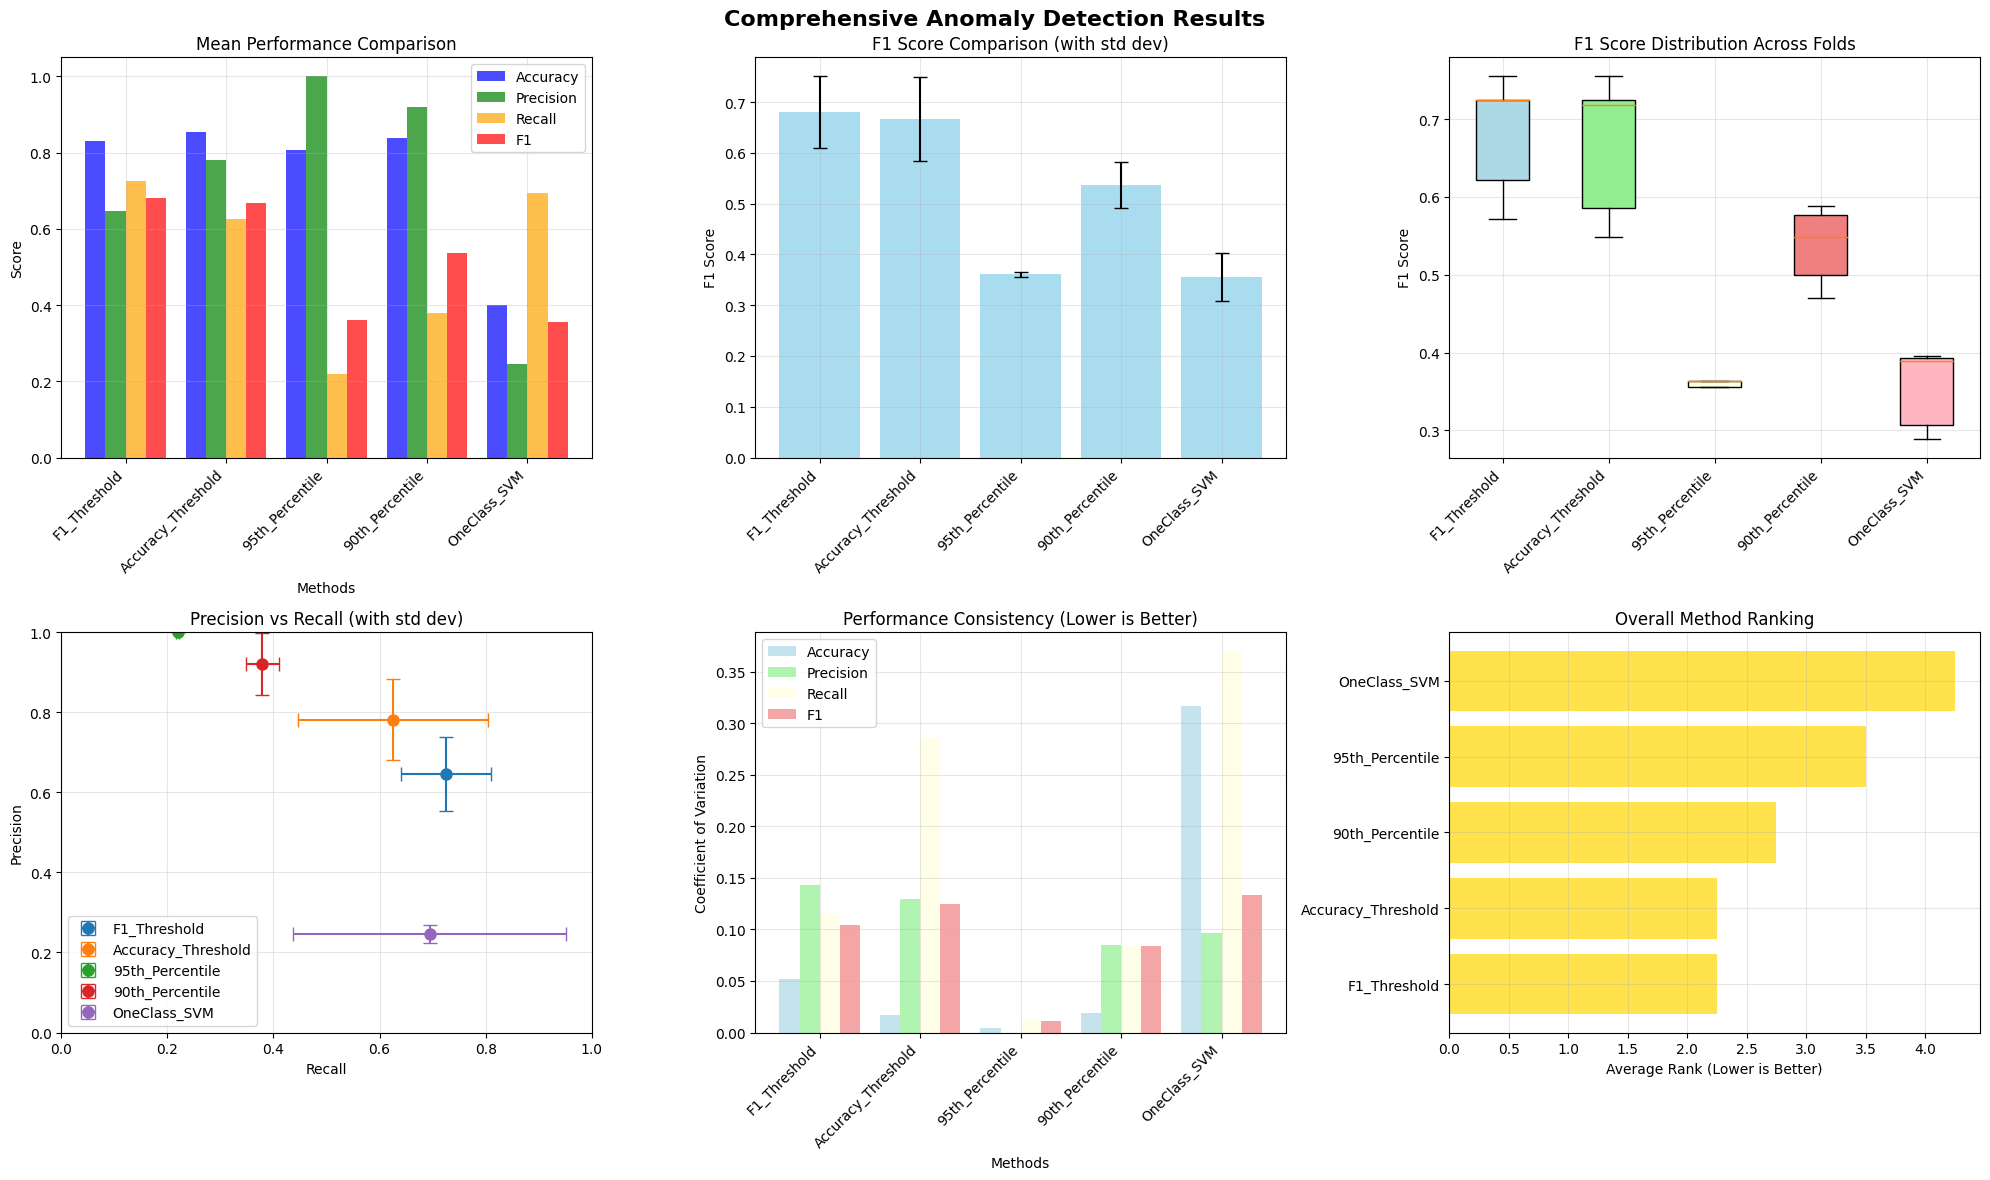


ANOMALY DETECTION RECOMMENDATIONS

🏆 BEST METHODS:
   • Best F1 Score: F1_Threshold (0.6798)
   • Best Accuracy: Accuracy_Threshold (0.8542)

📊 METHOD CHARACTERISTICS:
   • F1_Threshold          : High Recall (catches more anomalies), Stable
   • Accuracy_Threshold    : High Precision (fewer false alarms), Variable
   • 95th_Percentile       : High Precision (fewer false alarms), Stable
   • 90th_Percentile       : High Precision (fewer false alarms), Stable
   • OneClass_SVM          : High Recall (catches more anomalies), Variable

🎯 USE CASE RECOMMENDATIONS:
   • For Critical Systems (minimize false negatives): Use method with highest recall
   • For Cost-Sensitive Systems (minimize false alarms): Use method with highest precision
   • For Balanced Performance: Use F1_Threshold
   • For Simplicity: Use 95th_Percentile - no hyperparameter tuning needed
   • For Robustness: Use OneClass_SVM - adapts to data distribution



({'F1_Threshold': {'accuracy': {'mean': 0.8297455968688846,
    'std': 0.04287820982955067,
    'values': [0.7551020408163265,
     0.8095238095238095,
     0.8707482993197279,
     0.8503401360544217,
     0.863013698630137]},
   'precision': {'mean': 0.646968961204832,
    'std': 0.0925744170515431,
    'values': [0.5,
     0.6052631578947368,
     0.78125,
     0.6744186046511628,
     0.6739130434782609]},
   'recall': {'mean': 0.7252252252252253,
    'std': 0.08394320029216011,
    'values': [0.6666666666666666,
     0.6388888888888888,
     0.6756756756756757,
     0.7837837837837838,
     0.8611111111111112]},
   'f1': {'mean': 0.6797570870370447,
    'std': 0.07071613181773843,
    'values': [0.5714285714285715,
     0.6216216216216216,
     0.7246376811594203,
     0.725,
     0.7560975609756099]}},
  'Accuracy_Threshold': {'accuracy': {'mean': 0.8542353927872519,
    'std': 0.014536652720865179,
    'values': [0.8435374149659864,
     0.8367346938775511,
     0.87755102040816

In [6]:
run_comprehensive_cross_validation_experiment(X_train, faulty_data, device, generated_data, epochs=200, batch_size=32)